In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Two pronged/step problem with two independent distribution to solve

1) Pricing distribution for the coach and First class compartments are independent of each other so those can be solved independently as two separate DPs

2) We intend to come up with a best strategy for maximizing the revenue problem

3) For the entire solution space (time from 0 to 365 days and seats availaibe) we intend to only consider the revenue section of the problem 



> As the cost (overbooking cost) section of the problem will only surface on the 0th day 


I will start with solving the two separate DP for coach and first class compartment 



# COACH Compartment 

Specifications

<table>
 <tr>
 <th>Price</th>
 <th>Probability of selling</th>
 <th>Probability of not selling</th>
 </tr>

 <tr>
 <th>350 H</th>
 <td>0.3</td>
 <td>0.7</td>
 </tr>

 <tr>
 <th>300 L</th>
 <td>0.65</td>
 <td>0.35</td>
 </tr>


 </table>
 </tr>

 Number of seats = 100
 Number of days=365
 Overbooking allowed =5 

 Therefore seat will have a domain of 100 to 1 + 0,-1,-2,-3,-4



 # First Class

Specifications

<table>
 <tr>
 <th>Price</th>
 <th>Probability of selling</th>
 <th>Probability of not selling</th>
 </tr>

 <tr>
 <th>425 H</th>
 <td>0.08</td>
 <td>0.92</td>
 </tr>

 <tr>
 <th>500 L</th>
 <td>0.04</td>
 <td>0.96</td>
 </tr>


 </table>
 </tr>

 Number of seats = 20
 Number of days=365



In [21]:
overbooking_coach=5
overbooking_firstClass=0

flight_specifics={
    'coach': dict(
        priceL = 300,
        priceH = 350,
        pL = [0.3,0.7], 
        pH = [0.6,0.4], 
        seats=100,
        days=365,
        overbooking=overbooking_coach
        ),

    'firstClass':dict(
        priceL = 425,
        priceH = 500,
        pL = [0.08,0.92],
        pH = [0.04,0.96],
        seats=20,
        days=365,
        overbooking=overbooking_firstClass        
                    )}
pd.DataFrame(flight_specifics)

,coach,firstClass
priceL,300,425
priceH,350,500
pL,"[0.3, 0.7]","[0.08, 0.92]"
pH,"[0.6, 0.4]","[0.04, 0.96]"
seats,100,20
days,365,365
overbooking,5,0


In [23]:
flight_specifics['coach']

{'days': 365,
 'overbooking': 5,
 'pH': [0.6, 0.4],
 'pL': [0.3, 0.7],
 'priceH': 350,
 'priceL': 300,
 'seats': 100}

In [27]:
def generate_choiceLattice(dict_specific,delta=1/(1+15/365)):
  priceL = dict_specific['priceL']
  priceH = dict_specific['priceH']
  pL = dict_specific['pL']
  pH = dict_specific['pH']

  delta = delta

  overbooking=dict_specific['overbooking']
  M = dict_specific['seats'] + overbooking
  T = dict_specific['days'] 

  sValues = np.arange(M+1) 
  tValues = np.arange(T+1) 
  sN = len(sValues)
  tN = len(tValues)

  V = np.zeros((sN,tN)) 
  U = np.zeros((sN,tN)) 

  V[:,tN-1] = 0 
  U[:,tN-1] =0

  for t in reversed(range(tN-1)):
    for s in range(sN):
      if s==0: 
        V[s,t]=0 
        U[s,t]=3 
      else:
        valueL = pL[1]*priceL + delta* (pL[0]*V[s,t+1] + pL[1]*V[s-1,t+1])
        valueH = pH[1]*priceH + delta* (pH[0]*V[s,t+1] + pH[1]*V[s-1,t+1]) 

        V[s,t]=max(valueL,valueH) 
        U[s,t]=np.argmax([valueL,valueH])+1 
  return (V,U)


v,u=generate_choiceLattice(flight_specifics['coach'])
flight_specifics['coach']['v']=v
flight_specifics['coach']['u']=u


v,u=generate_choiceLattice(flight_specifics['firstClass'])
flight_specifics['firstClass']['v']=v
flight_specifics['firstClass']['u']=u


# flight_specifics
# flight_specifics['firstClass']['v'].shape

(21, 366)

In [28]:
flight_specifics['coach'].keys()

dict_keys(['priceL', 'priceH', 'pL', 'pH', 'seats', 'days', 'overbooking', 'v', 'u'])

In [52]:
def simulate_revenue(dict_specifics,delta=1/(1+15/365)):
  s = dict_specifics['seats']+dict_specifics['overbooking']
  tN=dict_specifics['days']
  U=dict_specifics['u']
  V=dict_specifics['v']

  priceL = dict_specifics['priceL']
  priceH = dict_specifics['priceH']
  pL = dict_specifics['pL']
  pH = dict_specifics['pH']

  total_rev = 0 
  seats_left_vec = np.zeros(tN) # store how many seats
  revenue_vec = np.zeros(tN)
  price_vec = np.zeros(tN)
  


  for t in range(tN): 
      opt_price = U[s,t] 
      price_vec[t] = opt_price
      if opt_price == 1: 
          prob_sale = pL[0] 
          actual_price = priceL 
      elif opt_price == 2: 
          prob_sale = pH[0]
          actual_price = priceH
      else: 
          prob_sale = 0
          actual_price = 0

      sale = int(np.random.random(1)<prob_sale) 
      # print(sale)
      
      s = int(s - sale) #seats being reduced
      total_rev = total_rev + sale*actual_price*delta**(t-1) 
      seats_left_vec[t] = s 
      revenue_vec[t] = total_rev
  revenue_vec=np.array(revenue_vec)
  seats_left_vec=np.array(seats_left_vec)
  return (seats_left_vec,revenue_vec)

(336, 325)

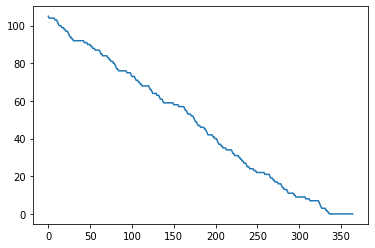

In [53]:
coach_seats,coach_revenue=simulate_revenue(flight_specifics['coach'])
plt.plot(coach_seats)


# np.where(coach_seats==5)
# np.max(coach_seats)
np.where(coach_seats==0)[0][0],np.where(coach_seats==5)[0][0]

seats_left= 2.0


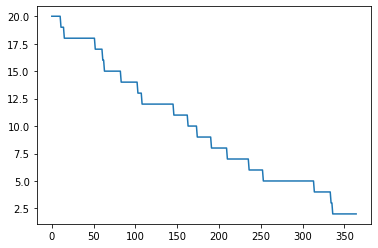

In [57]:
firstClass_seats,firstClass_revenue=simulate_revenue(flight_specifics['firstClass'])
plt.plot(firstClass_seats)

try:
  np.where(firstClass_seats==0)[0][0]
except:
  print(f'seats_left= {firstClass_seats[-1]}')

# ROUGH SPACE

In [4]:
V = np.zeros((sN,tN)) 
U = np.zeros((sN,tN)) 

# boundary/terminal condition
V[:,tN-1] = 0 # when the flight takes off you can't make any more money
U[:,tN-1] = 0 # 0 is the value for no tickets for sale


In [5]:
for t in reversed(range(tN-1)):
    for s in range(sN):
        if s==0: 
            V[s,t]=0 
            U[s,t]=3 
        else:
            valueL = pL[1]*priceL + delta* (pL[0]*V[s,t+1] + pL[1]*V[s-1,t+1])
            valueH = pH[1]*priceH + delta* (pH[0]*V[s,t+1] + pH[1]*V[s-1,t+1]) 

            V[s,t]=max(valueL,valueH) 
            U[s,t]=np.argmax([valueL,valueH])+1 


In [6]:
U[:10]

array([[3., 3., 3., ..., 3., 3., 0.],
       [2., 2., 2., ..., 1., 1., 0.],
       [2., 2., 2., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [13]:
# U[
# np.where(U==3)
  # ]
from copy import deepcopy

v_coach=deepcopy(V)
u_coach=deepcopy(U)


In [14]:
priceL = 425
priceH = 500
pL = [0.08,0.92] 
pH = [0.04,0.96] 

delta = 1/(1+15/365) #0.96

overbooking=0
M = 20 + overbooking
T = 365 

sValues = np.arange(M+1) #0 and other seats that are allowed
tValues = np.arange(T+1) 
sN = len(sValues)
tN = len(tValues)

In [15]:
for t in reversed(range(tN-1)):
    for s in range(sN):
        if s==0: 
            V[s,t]=0 
            U[s,t]=3 
        else:
            valueL = pL[1]*priceL + delta* (pL[0]*V[s,t+1] + pL[1]*V[s-1,t+1])
            valueH = pH[1]*priceH + delta* (pH[0]*V[s,t+1] + pH[1]*V[s-1,t+1]) 

            V[s,t]=max(valueL,valueH) 
            U[s,t]=np.argmax([valueL,valueH])+1 


In [16]:
U

array([[3., 3., 3., ..., 3., 3., 0.],
       [2., 2., 2., ..., 2., 2., 0.],
       [2., 2., 2., ..., 2., 2., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [17]:
v_firstClass=deepcopy(V)
u_firstClass=deepcopy(U)

In [7]:
1/(1+15/365)

0.9605263157894738

In [8]:
np.flip(np.arange(0,-5,-1))

array([-4, -3, -2, -1,  0])